In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

##  Apply the ARIMA(p,d,q) model on the datasets from chapters 4, 5 and 6

### ARIMA(p,d,q) in chapter 4 

In [2]:
df_ch4 = pd.read_csv('../data/widget_sales.csv')

df_ch4.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


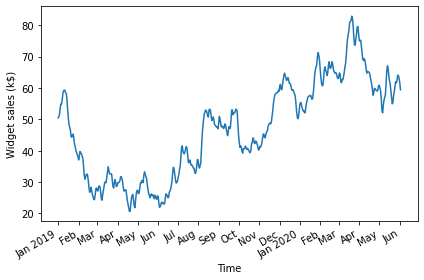

In [4]:
fig, ax = plt.subplots()

ax.plot(df_ch4['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [5]:
ad_fuller_result = adfuller(df_ch4['widget_sales'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.512166206935902
p-value: 0.5274845352272619


The series is not stationary, so let's apply differencing

In [6]:
df_ch4_diff = np.diff(df_ch4['widget_sales'], n=1)

ad_fuller_result = adfuller(df_ch4_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -10.576657780341957
p-value: 7.076922818587346e-19


The series is stationary. Therefore, we can set $d=1$.

In chapter 4, the test set was the last 50 timesteps. We split the same way here.

In [8]:
train = df_ch4[:-50]
test = df_ch4[-50:]

print(len(test))

50


In [9]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [10]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [11]:
result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",1251.431597
1,"(0, 2)",1254.409302
2,"(2, 1)",1254.961827
3,"(0, 3)",1255.826822
4,"(3, 0)",1255.967595
5,"(1, 2)",1255.982548
6,"(1, 1)",1256.284513
7,"(3, 1)",1256.850863
8,"(2, 2)",1256.918179
9,"(1, 3)",1257.643275


In chapter 4, we used a MA(2) model to predict our time series. Here, using the general modeling procedure, we find an ARIMA(3,1,3) model to have the lowest AIC. Note however that the second lowest AIC is for an ARIMA(0,1,2) model.

In [12]:
model = SARIMAX(train, order=(3,1,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           widget_sales   No. Observations:                  450
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -618.716
Date:                Mon, 10 Jan 2022   AIC                           1251.432
Time:                        16:27:42   BIC                           1280.181
Sample:                             0   HQIC                          1262.764
                                - 450                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3628      0.064     21.181      0.000       1.237       1.489
ar.L2         -1.3525      0.065    -20.834      0.000      -1.480      -1.225
ar.L3          0.3507      0.064      5.456      0.0

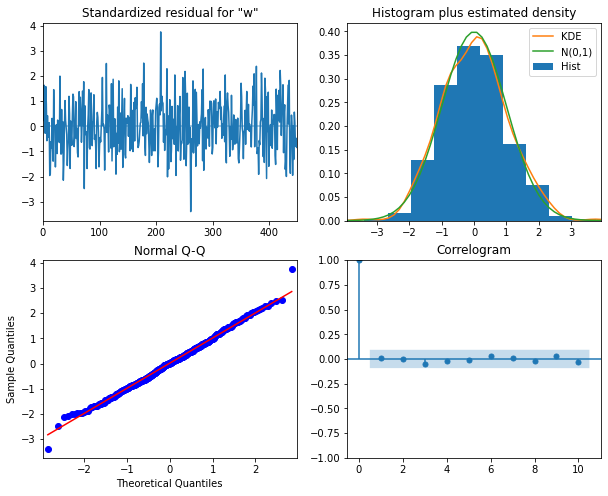

In [13]:
model_fit.plot_diagnostics(figsize=(10,8));

In [14]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

[0.89359539 0.97746624 0.97052322 0.99202271 0.99792771 0.99438491
 0.99713815 0.99878764 0.99953752 0.99982489]


In [16]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,1,3))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA

In [18]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_ch4, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_ch4, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df_ch4, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARIMA'] = pred_ARIMA

test.head()

,widget_sales,pred_mean,pred_last_value,pred_ARIMA
450,64.736005,45.472231,65.906136,64.811469
451,65.316972,45.472231,65.906136,64.718102
452,65.172070,45.558754,65.316972,66.242445
453,65.075506,45.558754,65.316972,66.608945
454,64.703173,45.644943,65.075506,64.994576


Using an ARIMA model, we get predictions in the same scale as the orginal data. Therefore, we can go straight to evaluating the model using the mean absolute error (MAE) and compare its performance to what we obtained in chapter 4.

In [19]:
from sklearn.metrics import mean_absolute_error

mean_mae = mean_absolute_error(test['widget_sales'], test['pred_mean'])
last_mae = mean_absolute_error(test['widget_sales'], test['pred_last_value'])
ARIMA_mae = mean_absolute_error(test['widget_sales'], test['pred_ARIMA'])

print(mean_mae, last_mae, ARIMA_mae)

14.220336729946744 1.819226540180243 1.5731245635276403


The ARIMA(3,1,3) model achieves a lower MAE than the MA(2) model we built in chapter 4.

### Chapter 5 

In [20]:
df_ch5 = pd.read_csv('../data/foot_traffic.csv')

df_ch5.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


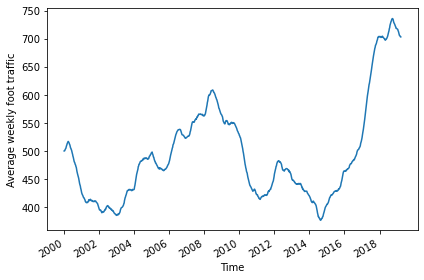

In [21]:
fig, ax = plt.subplots()

ax.plot(df_ch5['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [22]:
ad_fuller_result = adfuller(df_ch5['foot_traffic'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.1758885999240771
p-value: 0.683880891789618


The series is not stationary. Let's apply differencing.

In [23]:
df_ch5_diff = np.diff(df_ch5['foot_traffic'], n=1)

ad_fuller_result = adfuller(df_ch5_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.268231347422048
p-value: 6.369317654781179e-06


The series is now statioanry. We can set $d=1$.

In chapter 5, the test set had the last 52 timesteps. We do the same split here.

In [24]:
train = df_ch5[:-52]
test = df_ch5[-52:]

print(len(test))

52


In [25]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [26]:
result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 3)",2658.013441
1,"(3, 1)",2658.595081
2,"(3, 0)",2658.691777
3,"(2, 1)",2659.873751
4,"(3, 2)",2659.916852
5,"(2, 3)",2659.977855
6,"(3, 3)",2660.802093
7,"(2, 2)",2661.229924
8,"(2, 0)",2667.725827
9,"(1, 2)",2669.719835


Here, an ARIMA(1,1,3) model achieves the lowest AIC, but we can see that the top 3 models all have very similar AICs with differences in the decimal place. Notice that the third top model is an ARIMA(3,1,0).

In [27]:
model = SARIMAX(train, order=(3,1,0), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           foot_traffic   No. Observations:                  948
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -1325.346
Date:                Mon, 10 Jan 2022   AIC                           2658.692
Time:                        16:50:03   BIC                           2678.105
Sample:                             0   HQIC                          2666.090
                                - 948                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3165      0.033      9.603      0.000       0.252       0.381
ar.L2          0.4802      0.031     15.510      0.000       0.419       0.541
ar.L3          0.1077      0.034      3.156      0.0

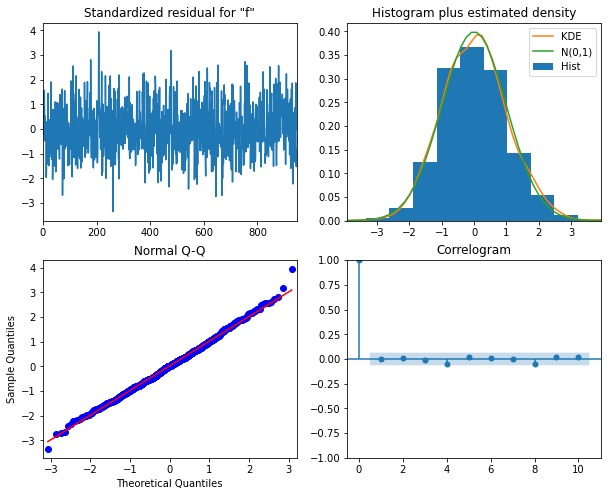

In [28]:
model_fit.plot_diagnostics(figsize=(10,8));

In [29]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

[0.99942003 0.99852437 0.99968546 0.99998334 0.99999921 0.99999982
 0.99999999 1.         1.         1.        ]


In [30]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,1,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA

In [32]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1    # Use a window of 1, just like in chapter 5

pred_mean = rolling_forecast(df_ch5, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_ch5, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df_ch5, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARIMA'] = pred_ARIMA

test.head()

,foot_traffic,pred_mean,pred_last_value,pred_ARIMA
948,701.686830,481.204906,702.463430,701.743717
949,701.112198,481.437237,701.686830,700.872282
950,700.221501,481.668474,701.112198,700.447460
951,699.937948,481.898288,700.221501,699.580032
952,698.107264,482.127321,699.937948,699.358669


In [33]:
from sklearn.metrics import mean_absolute_error

mean_mae = mean_absolute_error(test['foot_traffic'], test['pred_mean'])
last_mae = mean_absolute_error(test['foot_traffic'], test['pred_last_value'])
ARIMA_mae = mean_absolute_error(test['foot_traffic'], test['pred_ARIMA'])

print(mean_mae, last_mae, ARIMA_mae)

227.9348827539398 1.4751845139589823 0.7524470893109568


Again, the ARIMA(3,1,0) achieves the best performance with the lowest MAE.

### Chapter 6 

In [34]:
df_ch6 = pd.read_csv('../data/bandwidth.csv')

df_ch6.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


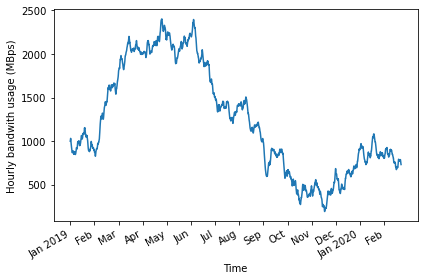

In [35]:
fig, ax = plt.subplots()

ax.plot(df_ch6['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [36]:
ad_fuller_result = adfuller(df_ch6['hourly_bandwidth'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.8714653199452314
p-value: 0.7972240255014685


The series is not stationary, let's apply differencing.

In [37]:
df_ch6_diff = np.diff(df_ch6['hourly_bandwidth'], n=1)

ad_fuller_result = adfuller(df_ch6_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -20.69485386378902
p-value: 0.0


The series is stationary, so we set $d=1$.

In chapter 6, we kept the last 168 timesteps for the test set. We split the same way here.

In [38]:
train = df_ch6[:-168]
test = df_ch6[-168:]

print(len(train))
print(len(test))

9832
168


In [39]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [40]:
result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",27991.063157
1,"(2, 3)",27991.286794
2,"(2, 2)",27991.602936
3,"(3, 3)",27993.416226
4,"(1, 3)",28003.348864
5,"(1, 2)",28051.350913
6,"(3, 1)",28071.155049
7,"(3, 0)",28095.617602
8,"(2, 1)",28097.250206
9,"(2, 0)",28098.407146


The ARIMA(3,1,2) model achieves the lowest AIC, but it is only slightly lower than the ARIMA(2,1,2) model.

In [41]:
model = SARIMAX(train, order=(2,1,2), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       hourly_bandwidth   No. Observations:                 9832
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -13990.801
Date:                Mon, 10 Jan 2022   AIC                          27991.603
Time:                        16:59:30   BIC                          28027.569
Sample:                             0   HQIC                         28003.788
                               - 9832                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

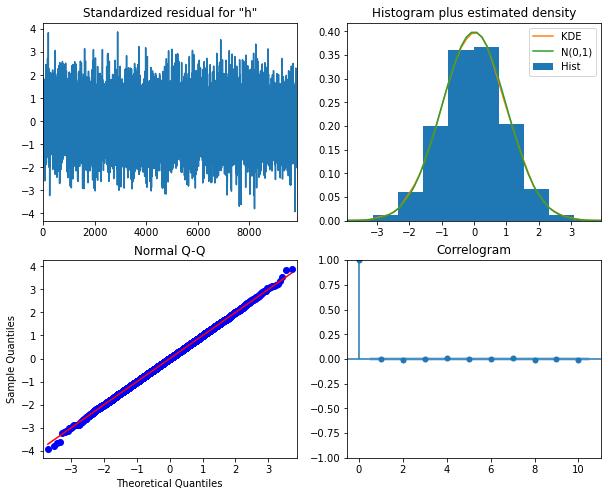

In [42]:
model_fit.plot_diagnostics(figsize=(10,8));

In [43]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

[0.96502014 0.99743637 0.99890122 0.9999166  0.99999392 0.99999749
 0.99999966 0.99999997 1.         1.        ]


In [44]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,1,2))    # Set the right ARIMA parameters
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA

In [45]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2    # Use a window of 2, just like in chapter 6

pred_mean = rolling_forecast(df_ch6, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_ch6, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df_ch6, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARIMA'] = pred_ARIMA

test.head()

,hourly_bandwidth,pred_mean,pred_last_value,pred_ARIMA
9832,717.176939,1241.072644,723.120934,717.660272
9833,711.311745,1241.072644,723.120934,712.769646
9834,708.114679,1240.965500,711.311745,705.975840
9835,707.024482,1240.965500,711.311745,701.224109
9836,707.689774,1240.857042,707.024482,706.648886


In [46]:
mean_mae = mean_absolute_error(test['hourly_bandwidth'], test['pred_mean'])
last_mae = mean_absolute_error(test['hourly_bandwidth'], test['pred_last_value'])
ARIMA_mae = mean_absolute_error(test['hourly_bandwidth'], test['pred_ARIMA'])

print(mean_mae, last_mae, ARIMA_mae)

497.927419811828 2.8444991498767638 1.384422458512391


Again, the ARIMA(2,1,2) achieves the best performance since it has the lowest MAE.